In [11]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


In [12]:
# Load EMNIST ("byclass" = all digits + letters)
(ds_train, ds_test), ds_info = tfds.load(
    'emnist/byclass',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True
)


/Users/volowofe/dev/private/HandwritingAI/venv_ai/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Dl Completed...: 0 url [00:00, ? url/s]
Dl Completed...: 100%|██████████| 1/1 [02:57<00:00, 176.16s/ url]

Extraction completed...: 100%|██████████| 4/4 [00:02<00:00,  1.85 file/s]
                                                                        

Dataset emnist downloaded and prepared to /Users/volowofe/tensorflow_datasets/emnist/byclass/3.1.0. Subsequent calls will reuse this data.


tfds.core.DatasetInfo(
    name='emnist',
    full_name='emnist/byclass/3.1.0',
    description="""
    The EMNIST dataset is a set of handwritten character digits derived from the NIST Special Database 19 and converted to a 28x28 pixel image format and dataset structure that directly matches the MNIST dataset.
    
    Note: Like the original EMNIST data, images provided here are inverted horizontally and rotated 90 anti-clockwise. You can use `tf.transpose` within `ds.map` to convert the images to a human-friendlier format.
    """,
    config_description="""
    EMNIST ByClass
    """,
    homepage='https://www.nist.gov/itl/products-and-services/emnist-dataset',
    data_dir='/Users/volowofe/tensorflow_datasets/emnist/byclass/3.1.0',
    file_format=tfrecord,
    download_size=535.73 MiB,
    dataset_size=349.16 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=62),
    }),
    supe

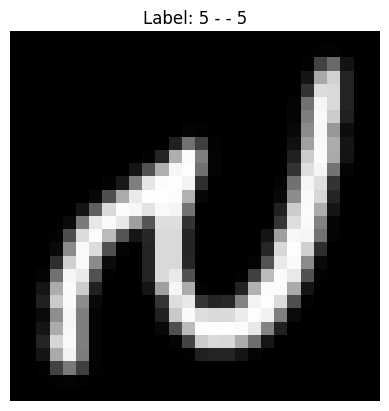

In [19]:
print(ds_info)

# Preview an example
for image, label in ds_train.take(1):
    plt.imshow(tf.squeeze(image), cmap='gray')
    plt.title(f"Label: {label} - - {label.numpy()}")
    plt.axis('off')
    plt.show()


In [20]:
NUM_CLASSES = ds_info.features['label'].num_classes

def preprocess(image, label):
    # Rotate image upright
    image = tf.image.rot90(image, k=3)
    image = tf.image.flip_left_right(image)
    
    # Normalize
    image = tf.cast(image, tf.float32) / 255.0

    # Add channel dimension
    image = tf.expand_dims(image, -1)

    # One-hot encode labels
    label = tf.one_hot(label, NUM_CLASSES)
    
    return image, label


In [21]:
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE

train_ds = ds_train.map(preprocess, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.cache().shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)

test_ds = ds_test.map(preprocess, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)


In [22]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Input(shape=(28, 28, 1)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(NUM_CLASSES, activation='softmax')
])


In [24]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_ds, validation_data=test_ds, epochs=5)


Epoch 1/5
10906/10906 ━━━━━━━━━━━━━━━━━━━━ 139s 13ms/step - accuracy: 0.7891 - loss: 0.6764 - val_accuracy: 0.8520 - val_loss: 0.4032
Epoch 2/5
10906/10906 ━━━━━━━━━━━━━━━━━━━━ 109s 10ms/step - accuracy: 0.8578 - loss: 0.3919 - val_accuracy: 0.8613 - val_loss: 0.3779
Epoch 3/5
10906/10906 ━━━━━━━━━━━━━━━━━━━━ 110s 10ms/step - accuracy: 0.8656 - loss: 0.3629 - val_accuracy: 0.8617 - val_loss: 0.3714
Epoch 4/5
10906/10906 ━━━━━━━━━━━━━━━━━━━━ 110s 10ms/step - accuracy: 0.8707 - loss: 0.3452 - val_accuracy: 0.8645 - val_loss: 0.3716
Epoch 5/5
10906/10906 ━━━━━━━━━━━━━━━━━━━━ 109s 10ms/step - accuracy: 0.8742 - loss: 0.3326 - val_accuracy: 0.8633 - val_loss: 0.3743


In [26]:
model.save("../models/emnist.keras")

In [27]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(test_ds)

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


1818/1818 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8629 - loss: 0.3748

Test Loss: 0.3743
Test Accuracy: 0.8633


In [55]:
from PIL import Image
import numpy as np
import tensorflow as tf

def prepare_image(img_path):
    """
    Prepares a custom image to match EMNIST format.
    """
    img = Image.open(img_path).convert('L')  # Convert to grayscale
    img = img.resize((28, 28))               # Resize to 28x28

    # Convert to numpy and invert (EMNIST is white BG, black ink)
    img = np.array(img)
    img = 255 - img  # Invert if needed (depends on your image)

    # Rotate to match EMNIST orientation
    img = np.rot90(img, k=1)
    img = np.fliplr(img)

    # Normalize to [0, 1]
    img = img.astype("float32") / 255.0

    # Reshape to match model input: (1, 28, 28, 1)
    img = np.expand_dims(img, axis=(0, -1))

    return img

import tensorflow_datasets as tfds

# Load label info from emnist/byclass
ds_info = tfds.builder('emnist/byclass').info
label_map = ds_info.features['label'].int2str  # Maps class index to character




In [69]:
img_path = "../mnist_image.png"
processed_img = prepare_image(img_path)

# Get prediction
prediction = model.predict(processed_img)
predicted_class = np.argmax(prediction[0])
confidence = np.max(prediction[0])

predicted_char = label_map(predicted_class)

print(f"Predicted EMNIST char: '{(predicted_char)}'")
print(f"Predicted class: {chr(predicted_class)}, Confidence: {confidence:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted EMNIST char: '36'
Predicted class: $, Confidence: 0.5485


In [67]:
chr(52)

'4'